In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc
import random
import warnings

from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, log_loss, roc_curve, auc, accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error

import os
import sys
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
import optuna
from optuna import Trial


# ## Set python parameters
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
np.random.seed(2018)

gcol = 'real_nits_kw'


#Here for posterity
def sig(x,L=1,k=1,xo=0): #general form of logistic regression
    return L/(1 + np.e**(-k*(x-xo)))

def syndrop(x): #adds noise to synthetic drop data based on rate
    #at high x, sig approaches 1, highly likely to return a drop
    if np.random.rand() >= sig(x,k=17,xo=.17):
        return 0
    else:
        return 1  
    

#read in datasets
train = pd.read_csv("../preprocessing/output_data/train_X.csv")
train_y = pd.read_csv("../preprocessing/output_data/train_y.csv")
train_real_values = train_y[train_y.columns[0]].values
del train_y

test = pd.read_csv("../preprocessing/output_data/test_X.csv")
test_y = pd.read_csv("../preprocessing/output_data/test_y.csv")
test_real_values = test_y[test_y.columns[0]].values
del test_y

cats = np.load("../../input_data/historical/new_remapped_labels_2020_10_27.npy",allow_pickle=True).item() #label encoding dict
catsi = [list(test.columns).index(i) for i in cats]

def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train,train_real_values):
        train_data = train.iloc[train_idx,:], train_real_values[train_idx]
        valid_data = train.iloc[valid_idx,:], train_real_values[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=cats,seed=seed,
                                            num_rounds=3000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

# Referred https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py

def fit_lgbm(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=3000):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 600),
        'objective': 'regression',
        'max_depth': trial.suggest_int('max_depth',6,12),
        'learning_rate': trial.suggest_loguniform('learning_rate',1e-3,1e-1),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric, "num_threads": 8,
        #'max_bin':63, 
        #'gpu_use_dp': False,
        "verbosity": -1, 
        'device': 'cpu', 
        #'gpu_device_id': 1
    }
    
    params['seed'] = seed

    early_stop = 500
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2', valid_name='valid_1')    

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [2]:
def o2(p2, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train,train_real_values):
        train_data = train.iloc[train_idx,:], train_real_values[train_idx]
        valid_data = train.iloc[valid_idx,:], train_real_values[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit2(p2, train_data, valid_data, cat_features=cats,seed=seed,
                                            num_rounds=3000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, train_real_values
    else:
        return valid_score

In [3]:
def fit2(p2, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=3000):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'objective': 'regression',
        "boosting": "gbdt",
        "bagging_freq": 5,
        "metric": metric, 
        "verbosity": -1, 
        'device': 'cpu', "num_threads": 8
    }
    
    params['seed'] = seed

    early_stop = 500
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train({**params,**p2},
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [4]:
runs = pd.read_csv("trial_output.csv")
runs = runs[runs.columns[:13]]
runs = runs.rename(columns=runs.loc[0].dropna().to_dict())
runs = runs.drop(0)
runs = runs.drop('Unnamed: 0',1)
runs = runs[runs.value.notnull()]
runs = runs.sort_values('value')
print(runs.shape)
brun = runs.iloc[0]
brun

(179, 12)


number                                      138
state                       TrialState.COMPLETE
value                                  0.642313
datetime_start       2020-01-10 09:41:38.298313
datetime_complete    2020-01-10 09:51:17.435984
bagging_fraction             0.8425733910104163
feature_fraction             0.5263520387515526
lambda_l1                   0.08251295665605048
lambda_l2                    1.4135426176004924
learning_rate              0.012396352849051039
max_depth                                    10
num_leaves                                  495
Name: 139, dtype: object

In [5]:
def fixlight(x):
    for i in ['number','state','value','datetime_start','datetime_complete']:
        del x[i]
    x = x.astype(float).to_dict()
    for i in ['max_depth','num_leaves']:
        x[i] = int(x[i])
    return x

b2 = fixlight(brun)

In [6]:
np.save('lightparam1.npy',b2)

In [7]:
oout = o2(b2, fast_check=False,return_info=True)

train 60675 valid 15169
training LGB:


/home/brandon/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[500]	training's l2: 0.469956	valid_1's l2: 0.644466
[1000]	training's l2: 0.410796	valid_1's l2: 0.642523
Early stopping, best iteration is:
[854]	training's l2: 0.426205	valid_1's l2: 0.642313
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.42620519779749744)]), 'valid_1': OrderedDict([('l2', 0.6423125740323974)])})
train 60675 valid 15169
training LGB:
Training until validation scores don't improve for 500 rounds
[500]	training's l2: 0.476114	valid_1's l2: 0.625216
[1000]	training's l2: 0.413973	valid_1's l2: 0.623467
Early stopping, best iteration is:
[987]	training's l2: 0.415476	valid_1's l2: 0.62338
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.41547595869327447)]), 'valid_1': OrderedDict([('l2', 0.6233803744877482)])})
train 60675 valid 15169
training LGB:
Training until validation scores don't improve for 500 rounds
[500]	tra

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
vals = np.zeros(test_real_values.shape[0])
for i in oout[1]:
    vals += i.predict(test)
vals = vals / len(oout[1])

In [10]:
bs = np.load("../preprocessing/scale_nits.npy",allow_pickle=True).item()
v2 = (vals * bs['std']) + bs['mean'] 
t2 = (test_real_values * bs['std']) + bs['mean']

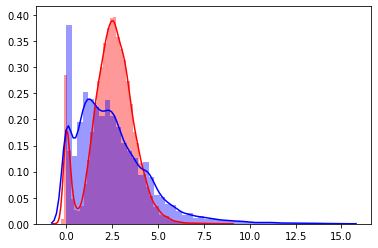

In [11]:
sns.distplot(v2,color='r',label='pred')
sns.distplot(t2,color='b',label='act')
plt.show()

Text(0, 0.5, 'actual icap kw')

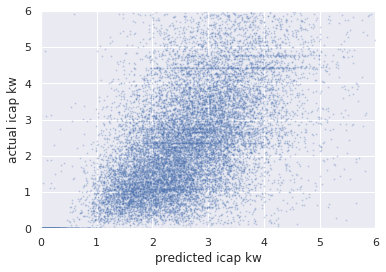

In [12]:
sns.set(style='darkgrid')
plt.scatter(v2,t2,alpha=0.2,s=1)
plt.xlim([0,6])
plt.ylim([0,6])
plt.xlabel("predicted icap kw")
plt.ylabel("actual icap kw")

In [13]:
mean_squared_error(t2,v2)

2.496490833930651

In [14]:
np.save("light_nits_models.npy",oout[1])

In [15]:
fs = []
for i in oout[1]:
    feature_imp = pd.DataFrame(sorted(zip(i.feature_importance(),train.columns)), columns=['Value','Feature']).sort_values('Value',ascending=False).set_index("Feature")
    fs.append(feature_imp)

In [16]:
fsc = pd.concat(fs,axis=1)
fsc['avv'] = fsc.mean(axis=1)
pd.set_option('max_rows',1000)
fsc.sort_values('avv')

Value  Value  Value  Value  Value      avv
FuelDescription                    360    397    345    335    421    371.6
EducationLevel                     794    856    625    594    907    755.2
DwellingType                       909    968    876    831   1031    923.0
Mail Public Responder Indicator   1480   1569   1310   1196   1561   1423.2
state                             1570   1605   1389   1265   1827   1531.2
Marital Status                    1752   2051   1535   1514   2042   1778.8
Home Ownership                    1685   1958   1860   1619   2080   1840.4
OccupationRollup                  1996   2327   1959   1702   2564   2109.6
Gender                            2296   2504   2150   2063   2668   2336.2
NetworthIndicator_Rollup          2716   3230   2578   2424   3323   2854.2
HHSIZE                            3071   3290   2798   2560   3531   3050.0
ESTINCOME                         2980   3456   2874   2696   3657   3132.6
ASSD_TOTAL_VALUE                  8525   9534   7986   7801   9920   8753.2
SALE_PRICE                        9785  10852   8879   8349  11712   9915.4
UNIVERSAL_BUILDING_SQUARE_FEET    9847  11277   9437   8846  12332  10347.8
YEAR_BUILT                       11890  12945  10551  10254  14146  11957.2
LAND_SQUARE_FOOTAGE_D            12284  14063  11448  10899  15322  12803.2
median_home_value                13207  14768  12446  11433  15592  13489.2
median_income                    13212  14753  12066  11794  15716  13508.2
ASSD_LAND_VALUE                  13686  15568  12983  12442  16960  14327.8
AGEOFINDIVIDUAL                  13821  15977  12934  12498  16991  14444.2
population                       14784  16080  13954  12914  17531  15052.6
latitude                         16177  18085  14874  14423  18398  16391.4
Home Value Range                 16509  18655  15647  14319  19341  16894.2
longitude                        17166  19160  16166  15431  19672  17519.0